In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.autonotebook import tqdm 

from traffic.core import Traffic
from traffic.data import airports
from traffic.data import navaids

/tmp/ipykernel_22413/1664592482.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Selecting Go-arounds

In [2]:
# ga = pd.read_csv("../deep_traffic_generation/data/data_lszh/eurocontrol_go_arounds_augmented_rawmetar.csv.gz")
# ga_lszh_14 = ga.query("(airport == 'LSZH') & (has_ga == True) & (runway == '14') ")

In [105]:
lszh = pd.read_parquet("../deep_traffic_generation/data/data_lszh/LSZH_landings.parquet")
ga_lszh_14 = lszh.query("(airport == 'LSZH') & (has_GA) & (ILS == '14') ")
ga_lszh_14["unique_ILS"] = ga_lszh_14.ILS_GA.apply(np.unique).apply(len) == 1
ga_lszh_14 = ga_lszh_14.query("unique_ILS")
ga_lszh_14 = ga_lszh_14.assign(year=lambda x: x.stop.dt.year)

/tmp/ipykernel_8878/2186695223.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ga_lszh_14["unique_ILS"] = ga_lszh_14.ILS_GA.apply(np.unique).apply(len) == 1


In [129]:
f_id_19 = ga_lszh_14.query("year == 2019").flight_id.values
f_id_20 = ga_lszh_14.query("year == 2020").flight_id.values
f_id_21 = ga_lszh_14.query("year == 2021").flight_id.values
f_id_22 = ga_lszh_14.query("year == 2022").flight_id.values

In [18]:
#/cluster/project/CRM/landings_eurocontrol -> 2020/2021/2022
#/cluster/project/CRM/landings -> 2019
import os

for file in os.listdir("/cluster/project/CRM/landings"):
    if "LSZH" in file:
        print(file)

for file in os.listdir("/cluster/project/CRM/landings_eurocontrol"):
    if "LSZH" in file:
        print(file)

LSZH_landings_2019_gnd.pkl
LSZH_landings_2019.pkl
LSZH_landings_2021.parquet
LSZH_landings_2021_processed.parquet
LSZH_landings_2021.parquet
LSZH_landings_2021.pkl
LSZH_landings_2021_processed.parquet
LSZH_landings_2020.parquet
LSZH_landings_2020_processed.parquet
LSZH_landings_2022.parquet
LSZH_landings_2022_processed.parquet


In [132]:
t1 = Traffic.from_file("/cluster/project/CRM/landings/LSZH_landings_2019.pkl")
t1_ga = t1[f_id_19]

t2 = Traffic.from_file("/cluster/project/CRM/landings_eurocontrol/LSZH_landings_2020.parquet")
t2_ga = t2[f_id_20]

t3 = Traffic.from_file("/cluster/project/CRM/landings_eurocontrol/LSZH_landings_2021.parquet")
t3_ga = t3[f_id_21]

t4 = Traffic.from_file("/cluster/project/CRM/landings_eurocontrol/LSZH_landings_2022.parquet")
t4_ga = t4[f_id_22]

In [135]:
t_ga = t1_ga + t2_ga + t3_ga + t4_ga
t_ga.to_pickle("../deep_traffic_generation/data/data_lszh/ga_14.pkl")

# Processing Go-Arounds 14

In [ ]:
# Go arounds between 2019 and 2022
t_ga1 = Traffic.from_file("../deep_traffic_generation/data/data_lszh/ga_14_filtered.pkl").resample("1s").airborne().eval(desc = "2019-2022", max_workers =20)
#Drop types L1P, H1T, H1P, H2T
lszh = pd.read_parquet("../deep_traffic_generation/data/data_lszh/LSZH_landings.parquet")
ga_lszh_14 = lszh.query("(airport == 'LSZH') & (has_GA) & (ILS == '14') ")
ga_lszh_14["unique_ILS"] = ga_lszh_14.ILS_GA.apply(np.unique).apply(len) == 1
ga_lszh_14 = ga_lszh_14.query("unique_ILS")
ga_lszh_14 = ga_lszh_14.query("type not in ['H2T', 'L1P', 'H1T', 'H1P']") # Verified: none are still from commercial aviation
t_ga1 = t_ga1.query(f"flight_id in {list(ga_lszh_14.flight_id.values)}")

# Go arounds between 2017 and 2018 (already cleaned)
t_ga2 = Traffic.from_file("../deep_traffic_generation/data/data_lszh/ga_OSN21.parquet").resample("1s").airborne().eval(desc = "2017-2019", max_workers =20)
t_ga2 = Traffic(t_ga2.data[t_ga2.data.timestamp < pd.Timestamp('2019-01-01', tz ="UTC")]) # avoid having 2 times 2019

t_ga = t_ga1 + t_ga2
t_ga.to_pickle("../deep_traffic_generation/data/data_lszh/ga_14_augmented.pkl")

In [2]:
t_ga = Traffic.from_file("../deep_traffic_generation/data/data_lszh/ga_14_augmented.pkl")

In [3]:
import re

#drop spurious flights
drop = []
pattern = r"^N\d"
for f in tqdm(t_ga):
    if "FCK" in f.flight_id:
        drop.append(f.flight_id)
    if re.match(pattern, f.flight_id):
        drop.append(f.flight_id)
    if "GSNCA" in f.flight_id:
        drop.append(f.flight_id)

drop.append("NJE834U_17267")
drop.append("NJE682R_16750")
        
t_ga = t_ga.query(f"flight_id not in {drop}")

  0%|          | 0/1050 [00:00<?, ?it/s]

In [4]:
#Normalize begining

def from_ils(f):
    candidate = f.aligned_on_ils("LSZH").next()
    if candidate is not None:
        t0 = candidate.start
        return f.after(t0)

t_ga = t_ga.iterate_lazy().pipe(from_ils).eval(desc = "", max_workers = 20)

Output()

/cluster/home/kruu/miniconda3/envs/pairs_generation/lib/python3.9/site-packages/traffic/core/lazy.py:231: TqdmExperimentalWarning: rich is experimental/alpha
  tasks_completed = tqdm(


In [5]:
spurious_id = ["BAW720T_15582", 
               "SWR57N_35429", 
               "EDW382_24398", 
               "SWR57N_35429", 
               "BAW720T_15582", 
               "EDW382_24398", 
               "AOJ52B_12095", 
               "EDW29Y_44772", 
               "SWR137Q_30670", 
               "PJS240_83415", 
               "SWR72TL_32014", 
               "DFQDP_6560", 
               "AEE5SZ_13572", 
               "AEA31AZ_3915", 
               "ACA878_125202",
               "OMA153_038", 
               "SWR202A_173", 
               "SWR285K_197", 
               "EJU3671_11229", 
               "FTY14_19802", 
               "OAW103_49992", 
               "SWR74A_164",
               "SWR44KX_604",
               "AUI471_234", 
               "EZY95DB_536", 
               "SWR1069_237",
               "None_322"]

t_ga_test = t_ga.query(f"flight_id not in {spurious_id}")

In [6]:
from traffic.data import airports
import traffic.core.geodesy as geo
from shapely.geometry import Polygon

a = airports["LSZH"].runways.data[airports["LSZH"].runways.data.name == "14"]
latlonbear14 = np.round(
    [a.latitude.values[0], a.longitude.values[0], a.bearing.values[0]], 3
)
latlonbear14

set1 = geo.destination(latlonbear14[0], latlonbear14[1], latlonbear14[2] + 90, 300)  # point A du seuil
set2 = geo.destination(latlonbear14[0], latlonbear14[1], latlonbear14[2] - 90, 300)  # point B du seuil
set3 = geo.destination(set2[0], set2[1], latlonbear14[2]+180, 800)  # Epaisseur
set4 = geo.destination(set1[0], set1[1], latlonbear14[2]+180, 800)  # Epaisseur

lat_point_list = [set1[0], set2[0], set3[0], set4[0]]
lon_point_list = [set1[1], set2[1], set3[1], set4[1]]

polygon_geom = Polygon(zip(lon_point_list, lat_point_list))

In [42]:
from ipyleaflet import Map, basemaps, Marker, Polygon
from ipywidgets import Layout
from traffic.data import airports
import traffic.core.geodesy as geo

map_ = Map(
    center=airports["LSZH"].latlon,
    zoom=10,
    basemap=basemaps.Stamen.Terrain,
    layout=Layout(width="100%", height="1000px"),
)

marker1 = Marker(location=navaids["OSNEM"].latlon, draggable=False)
map_.add_layer(marker1)

polygon1 = Polygon(
    locations=[set1[:2], set2[:2], set3[:2], set4[:2]],
    color="#4c78a8",
    fill_color="#4c78a8"
)
map_.add_layer(polygon1)

map_

Map(center=[47.458056, 8.548056], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

In [7]:
# End of trajectory: runway threshold

def till_runway(f):
    g = f.query("distance < 0")
    if g is None:
        print(f.flight_id)
        return None
    return f.before(g.at().timestamp) #take f because g has holes


t_ga_test= t_ga_test.distance(polygon_geom).pipe(till_runway).eval(desc="", max_workers = 20)

Output()

/cluster/home/kruu/miniconda3/envs/pairs_generation/lib/python3.9/site-packages/traffic/core/lazy.py:231: TqdmExperimentalWarning: rich is experimental/alpha
  tasks_completed = tqdm(


EWG5VJ_416


/tmp/ipykernel_22413/3828423196.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  latlon = t_ga_test.data.groupby(by="flight_id")["latitude", "longitude"].last()


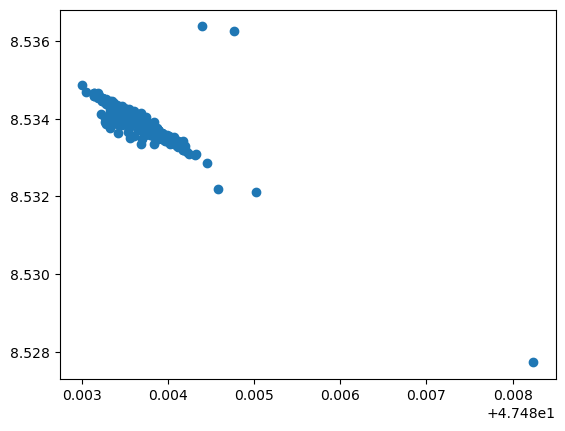

In [8]:
latlon = t_ga_test.data.groupby(by="flight_id")["latitude", "longitude"].last()
plt.scatter(latlon.latitude, latlon.longitude)
plt.show()

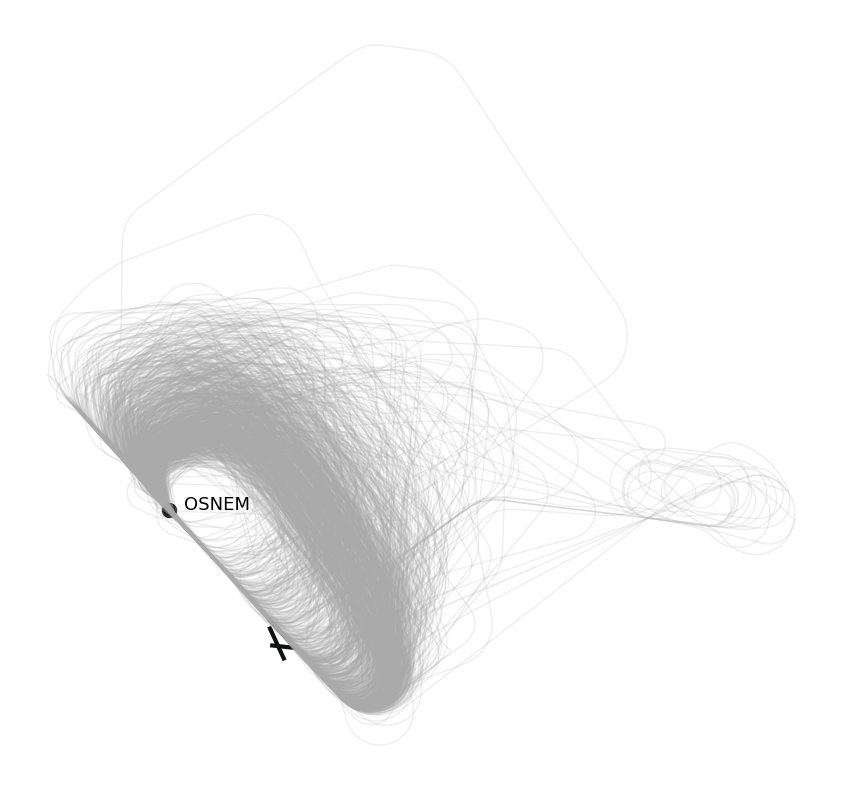

In [9]:
from traffic.core.projection import EuroPP
from traffic.data import navaids
from traffic.data import airports

with plt.style.context("traffic"):
    fig, ax = plt.subplots(figsize=(15, 10), subplot_kw=dict(projection=EuroPP()))

    t_ga_test.plot(ax, alpha=0.2)

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)
    navaids["OSNEM"].plot(ax)

plt.show()

In [10]:
#Drop trajs with only 1 alignement on ILs or more than 2
several_ga = []
for f in tqdm(t_ga_test):
    ils = f.aligned_on_ils("LSZH")
    nb = 0
    for seg in ils:
        if seg.max("ILS") == "14":
            nb+=1
    if nb != 2:
        several_ga.append(f.flight_id)
        print(f.flight_id)
        
t_ga_test = t_ga_test.query(f"flight_id not in {several_ga}")

  0%|          | 0/1002 [00:00<?, ?it/s]

DAAAX_449
EWG4KE_546
EWG9776_4426
IFA6091_8136
KLM57C_14164
NJE244C_14082
None_360
SIA346_58892
SWR121E_087
SWR1325_033
SWR145K_182
SWR1663_436
SWR5200_79085
SWR98A_460
VJT417_063


In [11]:
# Look for none in latitude, longitude, altitude, groundspeed, track -> No nan !
t_ga_test.data.isnull().any()

timestamp          False
alert               True
altitude           False
callsign           False
day                 True
destination         True
firstseen           True
geoaltitude         True
groundspeed        False
hour                True
icao24             False
lastseen            True
latitude           False
longitude          False
onground            True
origin              True
spi                 True
squawk              True
track              False
vertical_rate      False
flight_id          False
gs_pos_score        True
vr_alt_score        True
track_unwrapped    False
Alert               True
AltitudeGPS         True
OnGround            True
SPI                 True
ModeAOctal          True
SwissGridX          True
SwissGridY          True
SpeedX              True
SpeedY              True
distance           False
dtype: bool

In [12]:
# What about holdings ?
hold = t_ga_test.has("holding_pattern").eval(desc = "")
t_ga_test = t_ga_test-hold

Output()

In [13]:
hold[0].map_leaflet(highlight=dict(red="holding_pattern"))

Map(center=[47.64705832680239, 8.47740439254042], controls=(ZoomControl(options=['position', 'zoom_in_text', '…

In [27]:
#drop non detected holdings
def hold_amiki(f):
    g = f.query("distance < 2")
    if g is not None:
        return None
    else:
        return f

t_ga_test = t_ga_test.distance(navaids["AMIKI"]).pipe(hold_amiki).eval(desc="", max_workers = 20)

Output()

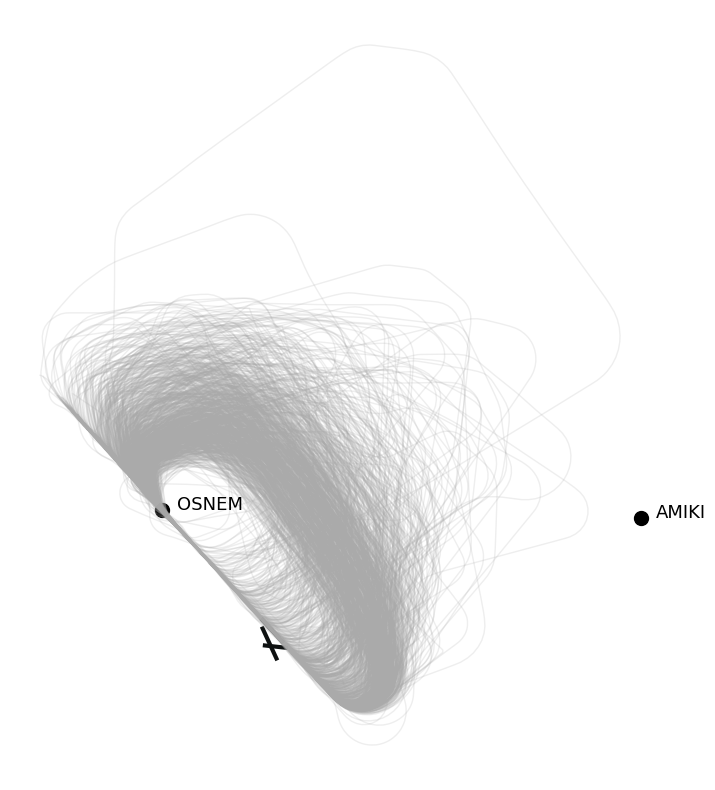

In [28]:
from traffic.core.projection import EuroPP
from traffic.data import navaids

with plt.style.context("traffic"):
    fig, ax = plt.subplots(figsize=(15, 10), subplot_kw=dict(projection=EuroPP()))

    t_ga_test.plot(ax, alpha=0.2)

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)
    navaids["OSNEM"].plot(ax)
    navaids["AMIKI"].plot(ax)

plt.show()

In [30]:
t_ga_test.to_pickle("../deep_traffic_generation/data/data_lszh/ga_14_augmented_cleaned.pkl")

# Processing take-offs 16

In [77]:
t_to = Traffic.from_file("../deep_traffic_generation/data/data_lszh/LSZH_takeoffs.parquet.gz")

In [78]:
def takeoff_16(f):
    candidate = f.takeoff_from_runway("LSZH").next()
    if candidate is not None:
        if candidate.max("runway") == '16':
            return f
        else:
            return None

t_to_16 = t_to.iterate_lazy().resample("1s").pipe(takeoff_16).eval(desc = "", max_workers = 50)

Output()

In [79]:
# Wrong heading start
first_track = t_to_16.data.groupby(by="flight_id")["track"].first()
idx = first_track[(first_track < 100) | (first_track > 250)].index.tolist()
t_to_16_test = t_to_16.query(f"flight_id not in {idx}")

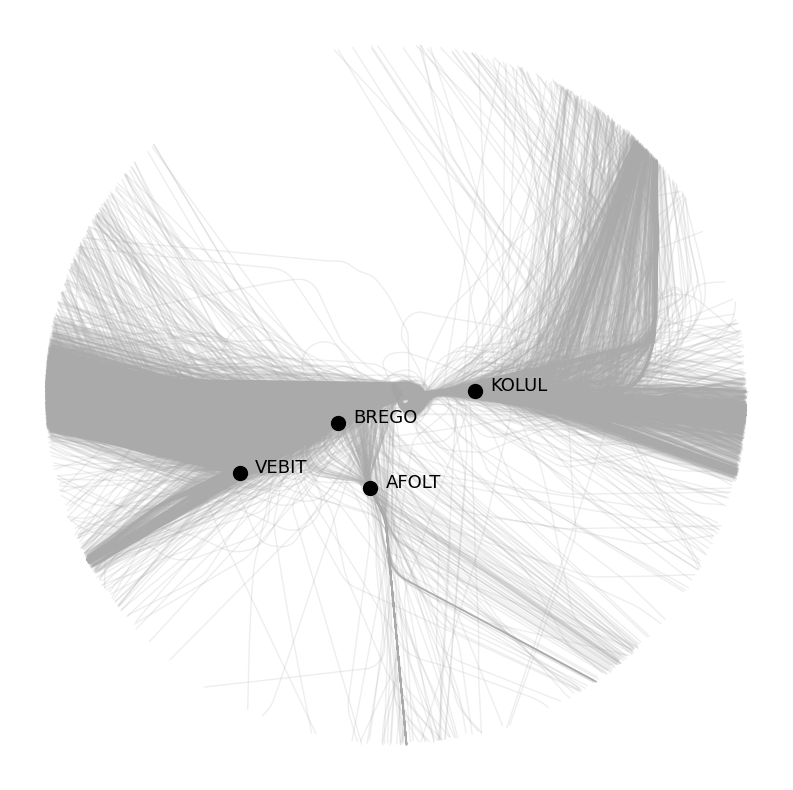

In [80]:
from traffic.core.projection import EuroPP
from traffic.data import airports
from traffic.data import navaids

with plt.style.context("traffic"):
    fig, ax = plt.subplots(figsize=(15, 10), subplot_kw=dict(projection=EuroPP()))

    t_to_16_test.plot(ax, alpha=0.2)

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)
    navaids["BREGO"].plot(ax, zorder = 4)
    navaids["VEBIT"].plot(ax, zorder = 4)
    navaids["KOLUL"].plot(ax, zorder = 4)
    navaids["AFOLT"].plot(ax, zorder = 4)

plt.show()

In [81]:
from traffic.data import airports
import traffic.core.geodesy as geo
from shapely.geometry import Polygon

a = airports["LSZH"].runways.data[airports["LSZH"].runways.data.name == "16"]
latlonbear16 = np.round(
    [a.latitude.values[0], a.longitude.values[0], a.bearing.values[0]], 3
)
print(latlonbear16)

set0 = geo.destination(latlonbear16[0], latlonbear16[1], latlonbear16[2], 3700)  
set1 = geo.destination(set0[0], set0[1], set0[2] + 90, 400)  # point A du seuil
set2 = geo.destination(set0[0], set0[1], set0[2] - 90, 400)  # point B du seuil
set3 = geo.destination(set2[0], set2[1], latlonbear16[2], 800)  # Epaisseur
set4 = geo.destination(set1[0], set1[1], latlonbear16[2], 800)  # Epaisseur

lat_point_list = [set1[0], set2[0], set3[0], set4[0]]
lon_point_list = [set1[1], set2[1], set3[1], set4[1]]

polygon_geom = Polygon(zip(lon_point_list, lat_point_list))

[ 47.476   8.536 154.977]


In [82]:
from ipyleaflet import Map, basemaps, Marker, Polygon
from ipywidgets import Layout
from traffic.data import airports
import traffic.core.geodesy as geo

map_ = Map(
    center=airports["LSZH"].latlon,
    zoom=10,
    basemap=basemaps.Stamen.Terrain,
    layout=Layout(width="100%", height="1000px"),
)


polygon1 = Polygon(
    locations=[set1[:2], set2[:2], set3[:2], set4[:2]],
    color="#4c78a8",
    fill_color="#4c78a8"
)
map_.add_layer(polygon1)

map_

Map(center=[47.458056, 8.548056], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

In [83]:
# Start of trajectory: runway threshold

def from_runway(f):
    g = f.query("distance < 0")
    if g is None:
        return None
    return f.after(g.at_ratio(0).timestamp) #take f because g has holes


t_to_16_test = t_to_16_test.distance(polygon_geom).pipe(from_runway).eval(desc="", max_workers = 20)

Output()

/tmp/ipykernel_22413/4193652082.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  latlon = t_to_16_test.data.groupby(by="flight_id")["latitude", "longitude"].first()


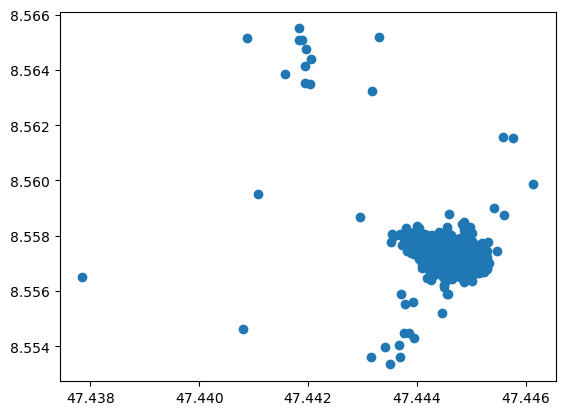

In [84]:
latlon = t_to_16_test.data.groupby(by="flight_id")["latitude", "longitude"].first()
plt.scatter(latlon.latitude, latlon.longitude)
plt.show()

In [85]:
t_to_16_test[:200].map_leaflet()

Map(center=[47.436759975464476, 8.259503602197983], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [86]:
t_to_16_test.to_pickle("../deep_traffic_generation/data/data_lszh/to_16_cleaned.pkl")

In [87]:
# The only important part for collision with Go-arounds is the beginning

def till_10nm(f):
    g = f.query("distance < 10")
    return g

a = t_to_16_test.distance(airports["LSZH"]).pipe(till_10nm).eval(desc = "", max_workers = 20)

Output()

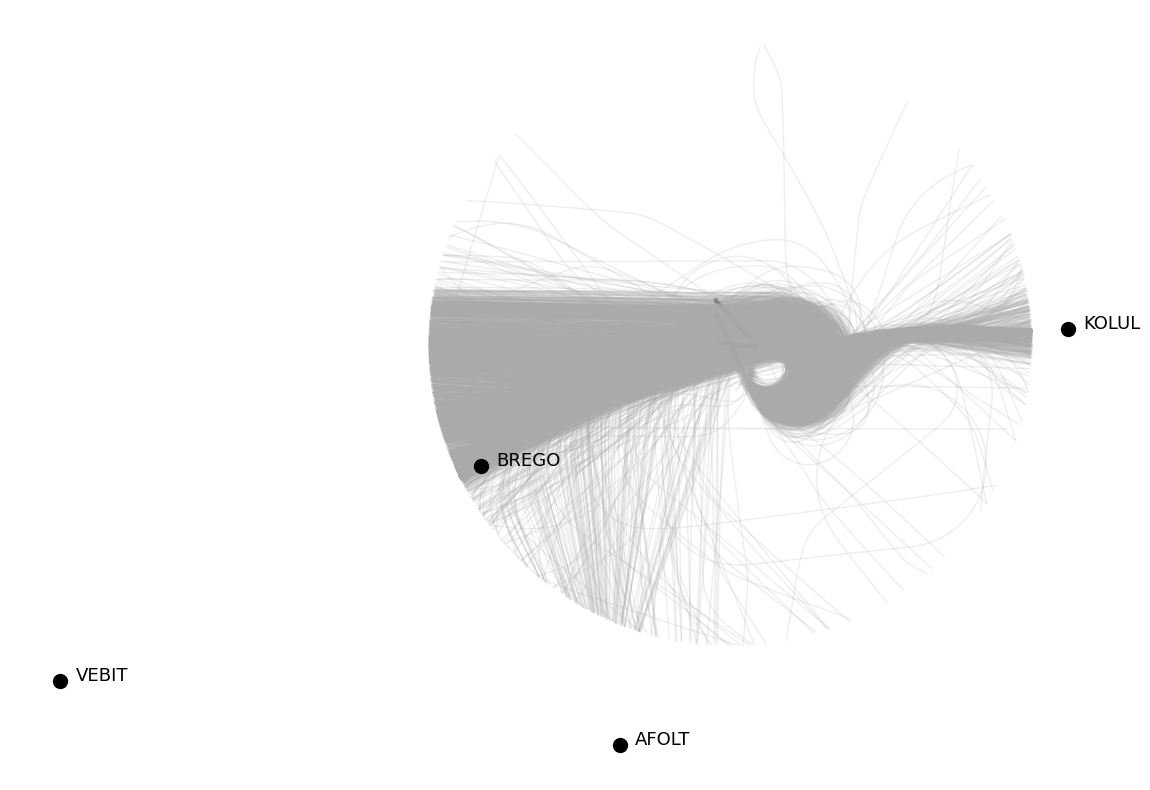

In [88]:
from traffic.core.projection import EuroPP
from traffic.data import airports
from traffic.data import navaids

with plt.style.context("traffic"):
    fig, ax = plt.subplots(figsize=(15, 10), subplot_kw=dict(projection=EuroPP()))

    a.plot(ax, alpha=0.2)

    airports["LSZH"].plot(ax, footprint=False, runways=dict(lw=1), labels=False)
    navaids["BREGO"].plot(ax, zorder = 4)
    navaids["VEBIT"].plot(ax, zorder = 4)
    navaids["KOLUL"].plot(ax, zorder = 4)
    navaids["AFOLT"].plot(ax, zorder = 4)

plt.show()

In [90]:
a.to_pickle("../deep_traffic_generation/data/data_lszh/to_16_cleaned_reduced.pkl")